# Import Libraries

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from IPython.display import Image
from torchvision.utils import save_image
%matplotlib inline

/Users/ferferof/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Download MNIST

In [2]:
mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

# Image features

In [3]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,0:5,0:5])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]]])


(tensor(-1.), tensor(1.))

In [4]:
img.shape

torch.Size([1, 28, 28])

# Plot a digit

Label: 5


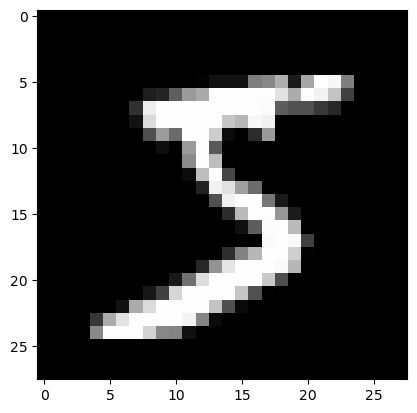

In [5]:
denorm = lambda x: ((x + 1) / 2).clamp(0, 1)

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [6]:
batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

# Discriminator Network

In [7]:
image_size = 784
hidden_size = 256

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# Generator Network

In [8]:
latent_size = 64

G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

Now, let's randomly generate an image by our generator

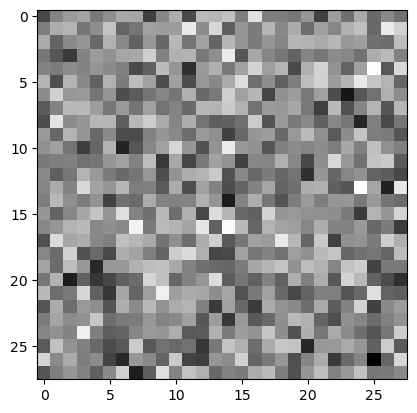

In [9]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())
plt.imshow(gen_imgs[0], cmap='gray');

# Define Discriminator Optimizer

In [10]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001)

In [11]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)
        
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    z = torch.randn(batch_size, latent_size)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = d_loss_real + d_loss_fake
    reset_grad()
    d_loss.backward()
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

# Define Generator Optimizer

In [12]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0001)

In [13]:
def train_generator():
    z = torch.randn(batch_size, latent_size)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1)
    g_loss = criterion(D(fake_images), labels)

    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

# Create Samples

In [14]:
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

## Real Samples

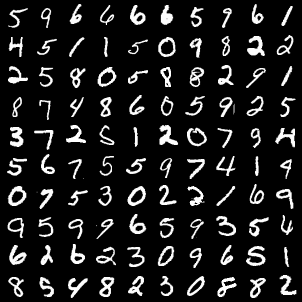

In [15]:
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

## Fake Samples

Saving fake_images-0000.png


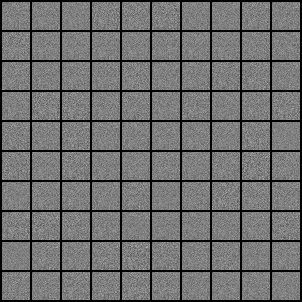

In [16]:
sample_vectors = torch.randn(batch_size, latent_size)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

# Training

In [17]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1)
        
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.3248, g_loss: 2.0427, D(x): 0.93, D(G(z)): 0.22
Epoch [0/300], Step [400/600], d_loss: 0.1650, g_loss: 2.6963, D(x): 0.94, D(G(z)): 0.10
Epoch [0/300], Step [600/600], d_loss: 0.2263, g_loss: 3.2754, D(x): 0.91, D(G(z)): 0.11
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.1994, g_loss: 3.4186, D(x): 0.91, D(G(z)): 0.08
Epoch [1/300], Step [400/600], d_loss: 0.2085, g_loss: 3.0316, D(x): 0.90, D(G(z)): 0.08
Epoch [1/300], Step [600/600], d_loss: 0.4027, g_loss: 2.9860, D(x): 0.90, D(G(z)): 0.21
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.2778, g_loss: 3.2210, D(x): 0.87, D(G(z)): 0.10
Epoch [2/300], Step [400/600], d_loss: 0.1079, g_loss: 3.4725, D(x): 0.96, D(G(z)): 0.06
Epoch [2/300], Step [600/600], d_loss: 0.8619, g_loss: 2.4955, D(x): 0.68, D(G(z)): 0.21
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.8198, g_loss: 2.4773, D(x): 0.67, D(G(z)): 0.11
Epoch [3/300], Step [400/6